In [152]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import heapq
import random

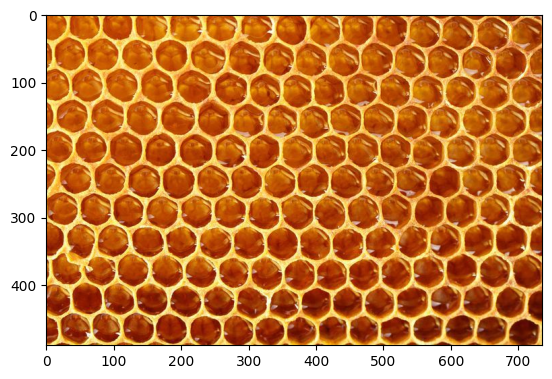

(490, 736, 3)


In [153]:
img=cv.imread("./pattern8.jpg")
img=cv.cvtColor(img,cv.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()
print(img.shape)

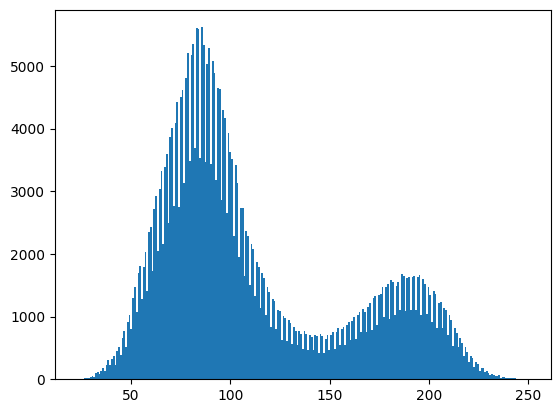

In [154]:
vals=img.mean(axis=2).flatten()
plt.hist(vals,bins=255)
plt.show()

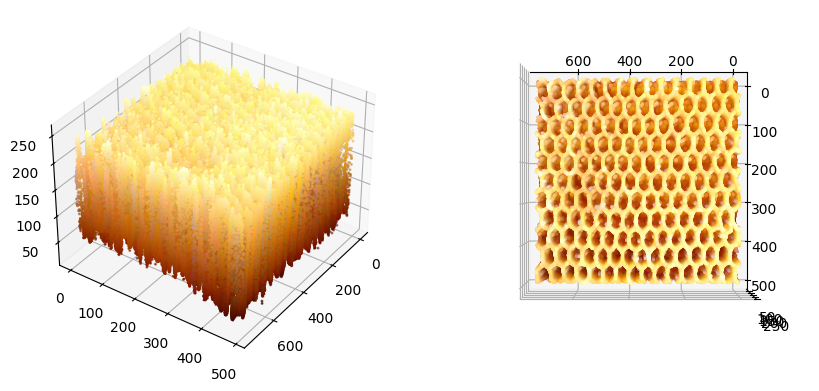

In [155]:
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.view_init(35,35)
ax2.view_init(90,0,-90)

x=[]
y=[]
z=[]

for i in range(img.shape[0]):
    x.append(i)
for i in range(img.shape[1]):
    y.append(i)

X,Y=np.meshgrid(y,x)
Z = np.dot(img[:,:,:], [0.2989, 0.5870, 0.1140])

colors = img.reshape(-1, 3) / 255.0

ax1.scatter(X.flatten(),Y.flatten(),Z.flatten(),c=colors,s=1)
ax2.scatter(X.flatten(),Y.flatten(),Z.flatten(),c=colors,s=1)
plt.show()

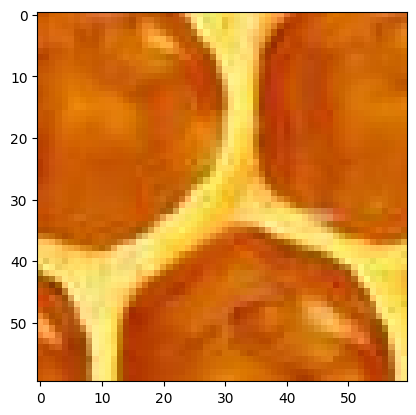

(60, 60, 3)


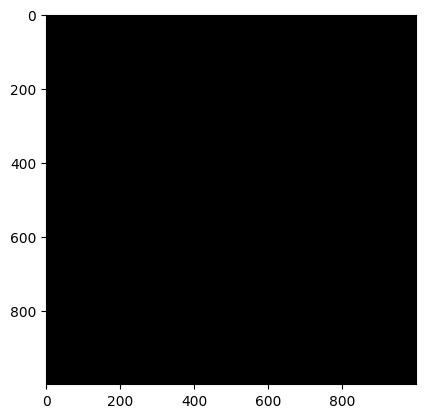

(1000, 1000, 3)


In [156]:
synthesis_img_size=(1000,1000,3)
block_size=(60,60,3)

synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

plt.imshow(img[:block_size[0],:block_size[1]])
plt.show()
print(img[:block_size[0],:block_size[1]].shape)
plt.imshow(synthesis_img)
plt.show()
print(synthesis_img.shape)

### Generic Block Tiling

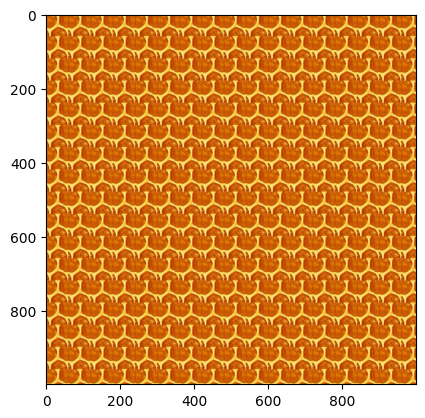

In [157]:
for i in range(0,synthesis_img.shape[0]):
    for j in range(0,synthesis_img.shape[1]):
        synthesis_img[i,j]=img[i%block_size[0],j%block_size[1]]
plt.imshow(synthesis_img)
plt.show()

### Random Block Tiling

In [158]:
def random_num(a):
    return random.randint(0, a)


def get_random_patch(img,synthesis_img_size,block_size,y,x):
    offset=(random_num(img.shape[0]-block_size[0]),random_num(img.shape[1]-block_size[1]))
    fill_size=list(block_size)
    if(y+block_size[0]>=synthesis_img_size[0]):
        fill_size[0]=synthesis_img_size[0]-y
    if(x+block_size[1]>=synthesis_img_size[1]):
        fill_size[1]=synthesis_img_size[1]-x
    patch=img[offset[0]:offset[0]+fill_size[0],offset[1]:offset[1]+fill_size[1]]

    return patch

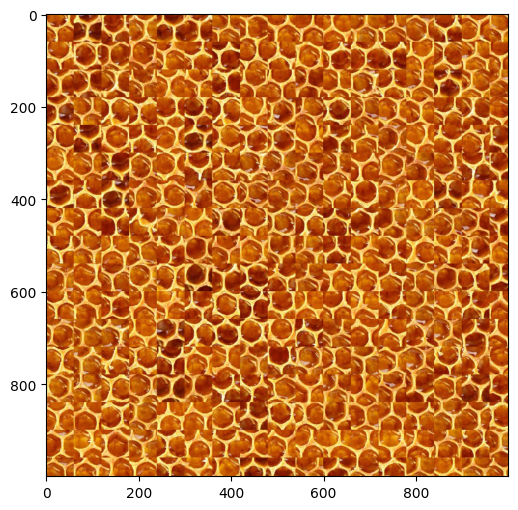

In [159]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

for y in range(0,synthesis_img.shape[0],block_size[0]):
    for x in range(0,synthesis_img.shape[1],block_size[1]):
        patch=get_random_patch(img,synthesis_img_size,block_size,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch
plt.figure(figsize=(6,6))
plt.imshow(synthesis_img)
plt.show()

### Random Block Tiling with Boundary Overlap

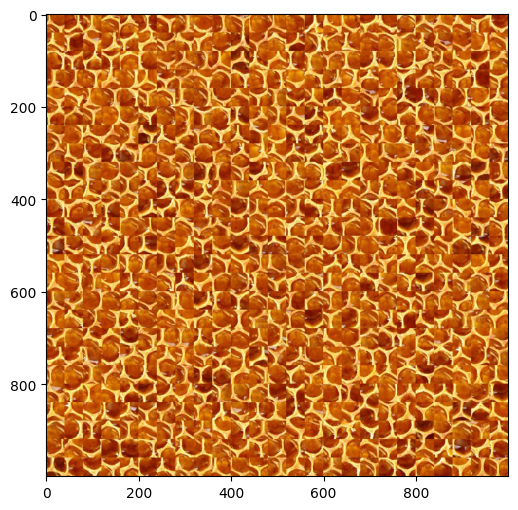

In [160]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

overlap=20
for y in range(0,synthesis_img.shape[0],block_size[0]-overlap):
    for x in range(0,synthesis_img.shape[1],block_size[1]-overlap):
        patch=get_random_patch(img,synthesis_img_size,block_size,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch

plt.figure(figsize=(6,6))
plt.imshow(synthesis_img)
plt.show()

### Random Block Tiling with Boundary Overlap and Minimum Error Boundary Cut

In [161]:
#Djikstra's Algorithm in the vertical direction and the destination is any node at a depth h
def min_cut_path(errors):
    pq=[(error,[i]) for i,error in enumerate(errors[0])]
    heapq.heapify(pq)
    h,w=errors.shape
    visited=set()
    while pq:
        error,path=heapq.heappop(pq)
        current_depth=len(path)
        current_index=path[-1]
        if current_depth==h:
            return path
        for i in -1,0,1:
            next_index=current_index+i
            if 0<=next_index<w:
                if(current_depth,next_index) not in visited:
                    cumError=error+errors[current_depth,next_index]
                    heapq.heappush(pq,(cumError,path+[next_index]))
                    visited.add((current_depth,next_index))

In [162]:
def min_cut_patch(patch,overlap,synthesis_img,y,x,show_cut=False):
    patch=patch.copy()
    min_cut=np.ones(patch.shape,dtype=bool)

    if(show_cut):
        fig,ax=plt.subplots(3,2)

    if x>0:
        left=patch[:,:overlap]-synthesis_img[y:y+patch.shape[0],x:x+overlap]
        leftL2=np.sum(left**2,axis=2)
        for i,j in enumerate(min_cut_path(leftL2)):
            min_cut[i,:j]=False
        if(show_cut):
            ax[0,0].imshow(leftL2)
            ax[0,1].imshow(min_cut[:,:,0],cmap="gray")
    if y>0:
        up=patch[:overlap,:]-synthesis_img[y:y+overlap,x:x+patch.shape[1]]
        upL2=np.sum(up**2,axis=2)
        for j,i in enumerate(min_cut_path(upL2.T)):
            min_cut[:i,j]=False
        if(show_cut):
            ax[1,0].imshow(upL2)
            ax[1,1].imshow(min_cut[:,:,0],cmap="gray")

    output=(patch*min_cut)+(synthesis_img[y:y+patch.shape[0],x:x+patch.shape[1]]*(~min_cut))
    if(show_cut):
        ax[2,0].imshow(patch)
        ax[2,1].imshow(patch*min_cut)
        plt.tight_layout()
        plt.show()
        plt.imshow(output)
        plt.show()

    return output

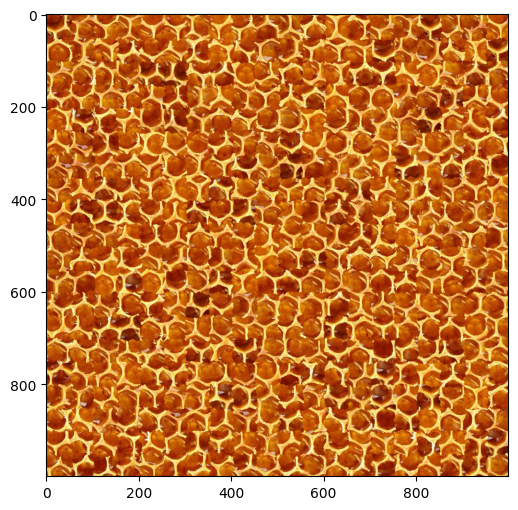

In [163]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

overlap=10
for y in range(0,synthesis_img.shape[0],block_size[0]-overlap):
    for x in range(0,synthesis_img.shape[1],block_size[1]-overlap):
        patch=get_random_patch(img,synthesis_img_size,block_size,y,x)
        patch=min_cut_patch(patch,overlap,synthesis_img,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch

plt.figure(figsize=(6,6))
plt.imshow(synthesis_img)
plt.show()

### Best Block Tiling with Boundary Overlap

In [164]:
def overlap_error(patch, synthesis_img, block_size, overlap, y, x):
    error = 0
    if x > 0:
        left = patch[:, :overlap] - synthesis_img[y:y+block_size[0], x:x+overlap]
        error += np.sum(left**2)
    if y > 0:
        up   = patch[:overlap, :] - synthesis_img[y:y+overlap, x:x+block_size[1]]
        error += np.sum(up**2)
    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - synthesis_img[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)
    return error

def get_best_patch(img, synthesis_img, block_size, overlap, y, x):
    fill_size=list(block_size)
    if(y+block_size[0]>=synthesis_img_size[0]):
        fill_size[0]=synthesis_img_size[0]-y
    if(x+block_size[1]>=synthesis_img_size[1]):
        fill_size[1]=synthesis_img_size[1]-x

    errors = np.zeros((img.shape[0] - fill_size[0], img.shape[1] - fill_size[1]))
    for i in range(img.shape[0] - fill_size[0]):
        for j in range(img.shape[1] - fill_size[1]):
            patch = img[i:i+fill_size[0], j:j+fill_size[1]]
            e = overlap_error(patch, synthesis_img, fill_size, overlap, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return img[i:i+fill_size[0], j:j+fill_size[1]]

In [165]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

overlap=20
for y in range(0,synthesis_img.shape[0],block_size[0]-overlap):
    for x in range(0,synthesis_img.shape[1],block_size[1]-overlap):
        patch=get_best_patch(img,synthesis_img,block_size,overlap,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch
plt.imshow(synthesis_img)
plt.show()

KeyboardInterrupt: 

### Best Block Tiling with Overlap and Min Boundary Cut

In [ ]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

overlap=30
for y in range(0,synthesis_img.shape[0],block_size[0]-overlap):
    for x in range(0,synthesis_img.shape[1],block_size[1]-overlap):
        patch=get_best_patch(img,synthesis_img,block_size,overlap,y,x)
        patch=min_cut_patch(patch,overlap,synthesis_img,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch
plt.imshow(synthesis_img)
plt.show()

### Finding Error of Overlapping Region and Choosing Block within a Threshold Error

In [214]:
# Performes template matching with the overlapping region, computing the cost of sampling each patch, based on the sum of squared differences (SSD).
def _ssd_patch(template, mask, texture):
    template = template.astype(np.float64)
    mask = mask.astype(np.float64)
    texture = texture.astype(np.float64)
    
    def _ssd(ch: int):
        return (
            ((mask[:,:,ch]*template[:,:,ch])**2).sum()\
            - 2 * cv.filter2D(texture[:,:,ch], ddepth=-1, kernel=template[:,:,ch]) \
            + cv.filter2D(texture[:,:,ch] ** 2, ddepth=-1, kernel=mask[:,:,ch])
        )

    ssd_b = _ssd(0)
    ssd_g = _ssd(1)
    ssd_r = _ssd(2)

    return ssd_b + ssd_g + ssd_r


def _choose_sample(cost: np.ndarray, tol: int) -> np.ndarray:
    """
    Selects a randomly sampled patch with low cost.

    :param cost: Cost matrix
    :param tol: Tolerance
    :return: Patch with min cost
    """
    idx = np.argpartition(cost.ravel(), tol-1)[:tol]
    lowest_cost = np.column_stack(np.unravel_index(idx, cost.shape))
    return random.choice(lowest_cost)


def quilt_simple(texture,synthesis_img_size,block_size,overlap,tol,show_cut=False):
    synthesis_img = np.zeros(synthesis_img_size)
    
    offset = (block_size[0] - overlap, block_size[1]-overlap)
    
    for y in range(0, synthesis_img_size[0], offset[0]):
        for x in range(0, synthesis_img_size[1], offset[1]):
            fill_size=list(block_size)
            if(y+block_size[0]>=synthesis_img_size[0]):
                fill_size[0]=synthesis_img_size[0]-y
            if(x+block_size[1]>=synthesis_img_size[1]):
                fill_size[1]=synthesis_img_size[1]-x

            template = np.array(synthesis_img[y:y+fill_size[0], x:x+fill_size[1], :], copy=True)
            mask = np.zeros(fill_size)
            
            if y == 0:
                mask[:, :overlap, :] = 1
            elif x == 0:
                mask[:overlap, :, :] = 1
            else:
                mask[:, :overlap, :] = 1
                mask[:overlap, :, :] = 1
                
            half = [fill_size[0]//2, fill_size[1]//2]
                
            ssd = _ssd_patch(template, mask, texture)
            if(show_cut):
                plt.imshow(ssd)
                plt.show()
            
                temp=ssd.copy()
                temp[:half[0],:]=0
                temp[:,:half[1]]=0
                temp[-half[0]:,:]=0
                temp[:,-half[1]:]=0
                plt.imshow(temp)
                plt.show()
            
            ssd = ssd[half[0]:-half[0], half[1]:-half[1]]
            i, j = _choose_sample(ssd, tol)
            synthesis_img[y:y+fill_size[0], x:x+fill_size[1], :] = texture[i:i+fill_size[0], j:j+fill_size[1], :]
            
            if(show_cut):
                plt.imshow(template.astype(np.uint8))
                plt.show()
                plt.imshow(mask)
                plt.show()
                plt.imshow(texture[i:i+fill_size[0], j:j+fill_size[1], :])
                plt.show()

    return synthesis_img.astype(np.uint8)

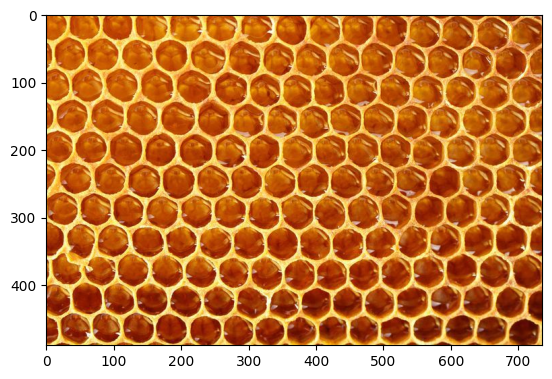

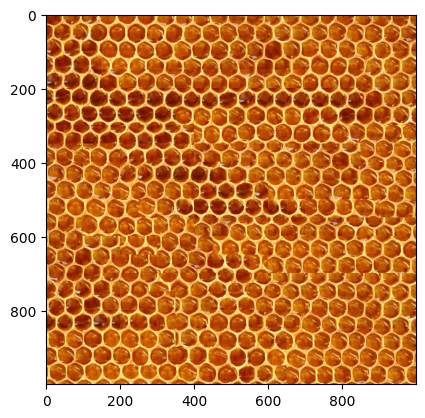

In [217]:
# texture = cv.cvtColor(cv.imread('pattern1.jpg'), cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

overlap=10
tol = 10
synthesis_img = quilt_simple(img, synthesis_img_size, block_size, overlap, tol,show_cut=False)
plt.imshow(synthesis_img)
plt.show()

### Finding Error of Template and Choosing Block with Least Error and using Min Boundary Cut